In [1]:
"""-------------------------------------------------
Author: Rajkumar Conjeevaram Mohan
Email: rajkumarcm@yahoo.com
Program: Language Model with Attention mechanism
-------------------------------------------------"""

'-------------------------------------------------\nAuthor: Rajkumar Conjeevaram Mohan\nEmail: rajkumarcm@yahoo.com\nProgram: Language Model with Attention mechanism\n-------------------------------------------------'

In [2]:
import pdb
import pickle
import math
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
import numpy as np
from numpy.random import random
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

In [3]:
%config Completer.use_jedi = False

### Load data

In [4]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [5]:
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, _ in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
for s, _ in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))

N_TR = len(training_sentences)
N_TS = len(testing_sentences)
N_VL = int(0.2 * N_TR)
validation_sentences = training_sentences[-N_VL:]
training_sentences = training_sentences[:-N_VL]
N_TR = len(training_sentences)

#### Limit data to subset of 1000 examples

In [6]:
# Temporary
training_sentences = training_sentences[:1000]
validation_sentences = validation_sentences[:200]
N_TR = 1000
N_VL = 200

In [7]:
print(f'Length of training set: {N_TR}')
print(f'Length of validation set: {N_VL}')
print(f'Length of testing set: {N_TS}')

Length of training set: 1000
Length of validation set: 200
Length of testing set: 25000


#### Tokenizer

In [8]:
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(training_sentences)
index_word = tokenizer.index_word

In [9]:
tmp_length1 = []
tmp_length2 = []

for sentence in training_sentences:
    tmp_tokens = tokenizer.texts_to_sequences([sentence])[0]
    tmp_length1.append(len(tmp_tokens))

for sentence in testing_sentences:
    tmp_tokens = tokenizer.texts_to_sequences([sentence])[0]
    tmp_length2.append(len(tmp_tokens))

tmp_length1 = np.max(tmp_length1)
tmp_length2 = np.max(tmp_length2)
MAX_LEN = np.max([tmp_length1, tmp_length2])

#### Create mask

In [10]:
noise = 0.15

def get_masks(tokens_seq):
    masks = []
    for tokens in tokens_seq:
        while True:
            previously_masked = False
            mask = []
            for token in tokens:
                if random() < noise:
                    if not previously_masked:
                        mask.append(True)
                    else:
                        mask.append(False)
                else:
                    mask.append(False)
            if any(mask):
                break
        masks.append(mask)
    return masks

### Data preprocessing

In [11]:
def preprocess(review):
    tokenized_review = tokenizer.texts_to_sequences([str(review)])[0]
    masks = get_masks([tokenized_review])
    tokenized_review = pad_sequences([tokenized_review], maxlen=MAX_LEN, padding='post', truncating='post')
    tokenized_review = tokenized_review.astype(np.int16)
    masks = pad_sequences(masks, maxlen=MAX_LEN, padding='post', truncating='post')
    masks = masks.astype(np.bool)
    return np.squeeze(tokenized_review), np.squeeze(masks)

In [12]:
def stream(data):
    for i in range(len(data)):
        review = data[i]
        tokenized_review, mask = preprocess(review)
        yield tokenized_review, mask

In [13]:
def make_dict(tokenized_review, mask):
    return {'input_key':tokenized_review, 'input_query':tokenized_review}, \
           {'mask':mask, 'target':tokenized_review}

#### Verify whether the preprocessing steps work as they should

In [14]:
train_gen = stream(training_sentences)
for review, mask in train_gen:
    tmp_review = review
    tmp_mask = mask
    print('Stream output shape-----------------------')
    print(f'train_token.shape={review.shape}, dtype={review.dtype}')
    print(f'mask.shape={mask.shape}, dtype={mask.dtype}')
    print('------------------------------------------\n')
    break

Stream output shape-----------------------
train_token.shape=(2332,), dtype=int16
mask.shape=(2332,), dtype=bool
------------------------------------------



In [15]:
# input_x, target_x = make_dict(tmp_review, tmp_mask)
# print(f'input_x["input_key"].shape={input_x["input_key"].shape}')
# print(f'input_x["input_key"].shape={input_x["input_key"].shape}')
# print(f'mask.shape={target_x["mask"].shape}')

### Now, let's create data pipeline

In [16]:
BATCH_SIZE = 1

train_gen = tf.data.Dataset.from_generator(generator=stream, 
                                           args=[training_sentences], 
                                           output_shapes=([MAX_LEN], [MAX_LEN]),
                                           output_types=(tf.int16, tf.bool)
                                          )
train_gen = train_gen.repeat().batch(BATCH_SIZE)#.map(make_dict).prefetch(3)

val_gen = tf.data.Dataset.from_generator(generator=stream,
                                         args=[validation_sentences],
                                         output_shapes=([MAX_LEN], [MAX_LEN]),
                                         output_types=(tf.int16, tf.bool))
val_gen = val_gen.repeat().batch(BATCH_SIZE)#.map(make_dict).prefetch(3)

tes_gen = tf.data.Dataset.from_generator(generator=stream,
                                         args=[testing_sentences],
                                         output_shapes=([MAX_LEN], [MAX_LEN]),
                                         output_types=(tf.int16, tf.bool))
tes_gen = val_gen.repeat().batch(BATCH_SIZE)#.map(make_dict).prefetch(3)

### Now once again let's confirm whether data generator work as they should

##### Use the following snippet when map function is enabled

In [17]:
# for review_dict, target_dict in train_gen.as_numpy_iterator():
#     print(f'review: {review_dict["input_key"].shape}')
#     print(f'mask: {target_dict["mask"].shape}')
#     break

##### Use this when map is disabled

In [18]:
for tokenized_review, mask in train_gen:
    input_x, target_x = make_dict(tokenized_review, mask)
    print('Output signature of train generator-------------')
    print(f'review: {tokenized_review.shape}')
    print(f'mask: {mask.shape}')
    print('------------------------------------------------\n')
    print(f'Sample tokenized review: \n{tokenized_review[0, :100]}')
    break

Output signature of train generator-------------
review: (1, 2332)
mask: (1, 2332)
------------------------------------------------

Sample tokenized review: 
[ 603   12   14   34  408  418   17   89   26 6481    9   33 1070 2999
   40  459 5012  208   23   73  149   15   12  238  337   26   63  315
  198    9  471   60   63   73  107  100   24 4056   12 1221  730  753
   12   17    7   34  361 3461  200 1853  494    2   84 1122  148   69
  155   51    2 9471 9472   69  266   63 2428   19 9473 2694 9474 6482
  969 5013    4   39 3462  128 1278   18 2999   14  167   15    3 1122
  774 9475    9    3   17   13   14 2695    5  102  134 1340   10  224
  663   13]


In [19]:
def accuracy(y_true, y_pred):
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int16)
    y_pred = tf.squeeze(y_pred)  # batch_size x max_len
    target = tf.cast(y_true['target'], tf.int16)  # batch_size x max_len
    correct = tf.cast(tf.equal(y_pred, target), dtype=tf.int16)
    mask = tf.cast(y_true['mask'], tf.int16)
    acc = tf.reduce_sum(correct * mask)/tf.reduce_sum(mask)
    return acc

In [20]:
def loss(y_true, y_pred):
    mask = y_true['mask']
    target = tf.one_hot(depth=VOCAB_SIZE+1, indices=tf.cast(y_true['target'], tf.int32))
    loss = -1 * (target * tf.math.log(y_pred + 1e-9))
    loss = tf.reduce_sum(loss, axis=-1)
    loss = tf.squeeze(loss)
    loss = loss * tf.cast(mask, dtype=tf.float32)
    loss = tf.reduce_sum(loss, axis=-1)
    loss = tf.reduce_mean(loss)
    return loss

#### Verify whether the loss work as it should

In [21]:
tmp_pred = tf.one_hot(indices=tf.cast(input_x['input_key'], dtype=tf.int32), depth=VOCAB_SIZE+1)
print(f'tmp_pred.shape={tmp_pred.shape}')
loss(target_x, tmp_pred)

tmp_pred.shape=(1, 2332, 10001)


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Verify whether accuracy is working correctly

In [22]:
accuracy(target_x, tmp_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [23]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

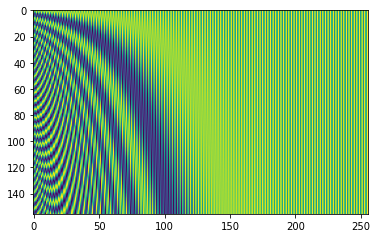

In [24]:
pe = positional_encoding(156, 256)
plt.figure()
plt.imshow(pe[0])
plt.show()

In [25]:
def decoder_block(x, ff_size, n_heads, key_dim, value_dim, dropout):
    mask = np.tril(np.ones([1, MAX_LEN+1, MAX_LEN+1])) # batch_size x (length_of_query+1) x length_of_key

    output = MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, value_dim=value_dim, 
                                dropout=dropout, use_bias=True)(query=x, value=x, attention_mask=mask)
    output += x
    output0 = LayerNormalization(axis=-1)(output)
    
    output = Dense(ff_size, activation='relu')(output0)
    output += output0
    output = LayerNormalization(axis=-1)(output)
    return output

In [26]:
def create_model1(d_model, n_heads, n_layers=1, ff_size=256, key_dim=256, value_dim=256, dropout=0.1):

    D_MODEL = d_model

    x0 = Input(shape=[MAX_LEN], batch_size=BATCH_SIZE, dtype=tf.int16, name='input_key')

    # # Shift Right
    x = Lambda(lambda y: tf.pad(y, paddings=[[0, 0], [1, 0]]))(x0)

    x = Embedding(input_dim=VOCAB_SIZE, output_dim=D_MODEL)(x)
    x += positional_encoding(MAX_LEN+1, D_MODEL)
    
    for _ in range(n_layers):
        x = decoder_block(x, ff_size, n_heads, key_dim, value_dim, dropout)
        
    x = Lambda(lambda x: x[:, :-1])(x)
    x = Dense(VOCAB_SIZE+1, use_bias=True)(x)  # 0 for padding, and (1-VOCAB_SIZE) for words
    x = Softmax(axis=-1)(x)
    
    model = Model(inputs=x0, outputs=x)
    model.summary()
    return model

In [27]:
## DO NOT DELETE THIS EVEN WHEN NOT IN USE AS THIS COULD BE VERY USEFUL FOR OTHER PROJECTS

def train(model, epochs, initial_epoch=0):
    
    train_loss_results = []
    train_accuracy_results = []

    vl_loss_results = []
    vl_accuracy_results = []
    
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
    lr_switch = {
                  1: 1e-5, # [20 - 40)
                  2: 1e-6, # [40 - 60)
                  3: 5e-7, # [60 - 80)
                  4: 1e-7, # [80 - 100]
    }
    
    def grad(model, input_x, targets):
        with tf.GradientTape() as tape:
            y_pred = model(input_x)
            loss_value = loss(targets, y_pred)
            acc = accuracy(targets, y_pred)
        return loss_value, acc, tape.gradient(loss_value, model.trainable_variables)
    
    for epoch in range(initial_epoch, epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.Mean()
        
        vl_loss_avg = tf.keras.metrics.Mean()
        vl_accuracy = tf.keras.metrics.Mean()

        for (tk_reviews, mask), _ in zip(train_gen, range(N_TR//BATCH_SIZE)):
            input_dict, target_dict = make_dict(tk_reviews, mask)

            tr_loss, tr_acc, grads = grad(model, tk_reviews, target_dict)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            epoch_loss_avg.update_state(tr_loss)
            epoch_accuracy.update_state(tr_acc)

        tr_avg_loss = epoch_loss_avg.result().numpy()
        tr_avg_acc = epoch_accuracy.result().numpy()
        epoch_loss_avg.reset_states()
        epoch_accuracy.reset_states()

        train_loss_results.append(tr_avg_loss)
        train_accuracy_results.append(tr_avg_acc)
        
        for (tk_reviews, mask), _ in zip(val_gen, range(N_VL//BATCH_SIZE)):
            input_dict, target_dict = make_dict(tk_reviews, mask)
            y_pred = model(tk_reviews)
            vl_loss = loss(target_dict, y_pred)
            vl_acc = accuracy(target_dict, y_pred)
            
            vl_loss_avg.update_state(vl_loss)
            vl_accuracy.update_state(vl_acc)
        
        vl_loss = vl_loss_avg.result().numpy()
        vl_acc = vl_accuracy.result().numpy()
        vl_loss_avg.reset_states()
        vl_accuracy.reset_states()
        
        vl_loss_results.append(vl_loss)    
        vl_accuracy_results.append(vl_acc)

        print("Epoch %d Loss: %.3f Accuracy: %.3f Val_Loss: %.3f Val_Accuracy: %.3f" %\
                      (epoch, tr_avg_loss, tr_avg_acc, vl_loss, vl_acc))
        
        old_lr = optimizer.learning_rate.numpy()
        if epoch%20 == 0:
            period = old_lr//20
            optimizer.learning_rate.assign(lr_switch.get(period, 1e-4))
            
    return [ np.array(train_loss_results)[..., None], \
             np.array(train_accuracy_results)[..., None], \
             np.array(vl_loss_results)[..., None], \
             np.array(vl_accuracy_results)[..., None] ]

In [28]:
EPOCHS = 50

### Effect of Conv1D in lieu to Positional Encoding

In [29]:
def create_model3(d_model, n_heads, n_layers=1, ff_size=256, key_dim=256, value_dim=256, dropout=0.1):

    D_MODEL = d_model

    x0 = Input(shape=[MAX_LEN], batch_size=BATCH_SIZE, dtype=tf.int16, name='input_key')

    # # Shift Right
    x = Lambda(lambda y: tf.pad(y, paddings=[[0, 0], [1, 0]]))(x0)

    x = Embedding(input_dim=VOCAB_SIZE, output_dim=D_MODEL)(x)
    x = Conv1D(filters=D_MODEL, kernel_size=3, padding='same')(x)
    
    for _ in range(n_layers):
        x = decoder_block(x, ff_size, n_heads, key_dim, value_dim, dropout)
        
    x = Lambda(lambda x: x[:, :-1])(x)
    x = Dense(VOCAB_SIZE+1, use_bias=True)(x)  # 0 for padding, and (1-VOCAB_SIZE) for words
    x = Softmax(axis=-1)(x)
    
    model = Model(inputs=x0, outputs=x)
    model.summary()
    return model

In [30]:
model3 = create_model3(d_model=256, n_heads=4, n_layers=1, ff_size=256, key_dim=256, value_dim=256, dropout=0.1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_key (InputLayer)          [(1, 2332)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (1, 2333)            0           input_key[0][0]                  
__________________________________________________________________________________________________
embedding (Embedding)           (1, 2333, 256)       2560000     lambda[0][0]                     
__________________________________________________________________________________________________
conv1d (Conv1D)                 (1, 2333, 256)       196864      embedding[0][0]                  
______________________________________________________________________________________________

In [31]:
tf.keras.utils.plot_model(
    model3, show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
tmp_performance3 = train(model3, EPOCHS)
tmp_file = open('conv_attention_perf.pkl', 'wb')
pickle.dump(tmp_performance3, tmp_file)
tmp_file.close()

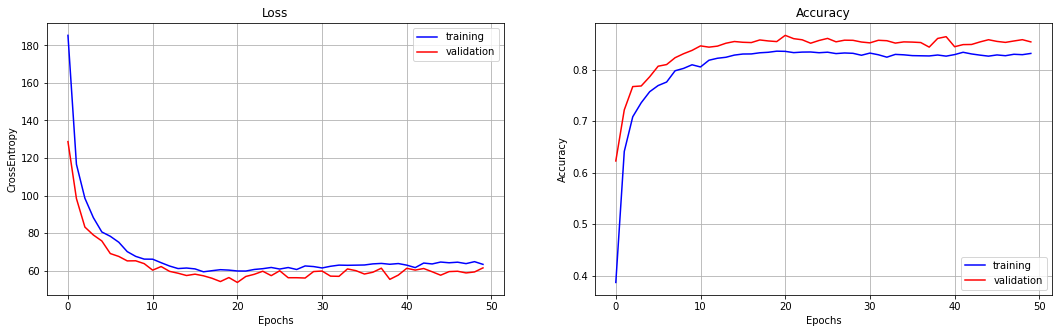

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].set_title('Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('CrossEntropy')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')

axes[0].plot(range(EPOCHS), tmp_performance3[0], '-b', label='training')
axes[0].plot(range(EPOCHS), tmp_performance3[2], '-r', label='validation')
axes[1].plot(range(EPOCHS), tmp_performance3[1], '-b', label='training')
axes[1].plot(range(EPOCHS), tmp_performance3[3], '-r', label='validation')

axes[0].grid(True)
axes[0].legend()
axes[1].grid(True)
axes[1].legend()
# axes[1].plot(range(len(train_accuracy_results)), train_accuracy_results, '-r', label='training')
plt.show()

In [32]:
# model3.save('model/conv_attention.h5')

In [33]:
model3.load_weights('model/conv_attention.h5')

#### Impressive results. Let's find out how it generates text

In [34]:
def detokenize(tokens):
    text = [index_word[token] for token in tokens]
    return text

In [53]:
print(training_sentences[2])  # Have tried using even the validation sentence, and it still doesn't work
tmp_tokenized = tokenizer.texts_to_sequences([training_sentences[2]])
tmp_padded = pad_sequences(tmp_tokenized, maxlen=MAX_LEN, padding='post', truncating='post')
tmp_pred = model3(tmp_padded)
print('\n')
print(f'Input tmp_tokenized[0][:20]: \n{tmp_tokenized[0][:20]}\n')
tmp_pred = list(np.argmax(tmp_pred[0, :20], axis=-1))
print(f'Predicted: \n{tmp_pred}\n')
print(f'Detokenized prediction: \n{detokenize(tmp_pred)}')

Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.


Input tmp_tokenized[0][:20]: 
[1724, 6484, 2, 9478, 2697, 2430, 9, 3, 854, 1341, 4, 3001, 1071, 4, 1342, 9479, 183, 601, 338, 16]

Predicted: 
[639, 525, 2, 513, 10, 758, 9, 3, 854, 491, 4, 297, 537, 4, 266, 38

In [50]:
sample_sentence = "Mann photographs the Alberta Rocky"
sample_tokenized = tokenizer.texts_to_sequences([sample_sentence])
initial_length = len(sample_tokenized[0])
full_length = len(tmp_tokenized[0])
print(sample_tokenized[0])
print(f'Initial length: {initial_length}')
print(f'Full length: {full_length}')
padded_tokens = pad_sequences(sample_tokenized, maxlen=MAX_LEN, padding='post', truncating='post').astype(np.int16)

[1724, 6484, 2, 9478, 2697]
Initial length: 5
Full length: 148


In [52]:
currentraining_sentences = initial_length-1
for i in range(current_length, 20):
    print(f'Input: \n{sample_tokenized}')
    print(f'Detokenized input: \n{detokenize(sample_tokenized[0])}')
    sample_pred = model3(padded_tokens)
#     pdb.set_trace()
    sample_pred = np.argmax(sample_pred[0, i])
    print(f'Predicted token: {sample_pred}')
    sample_tokenized[0].append(sample_pred)
    print(f'Updated Input: \n{sample_tokenized}\n\n')
    padded_tokens = pad_sequences(sample_tokenized, maxlen=MAX_LEN, padding='post', truncating='post').astype(np.int16)

Input: 
[[1724, 6484, 2, 9478, 2697]]
Detokenized input: 
['mann', 'photographs', 'the', 'alberta', 'rocky']
Predicted token: 525
Updated Input: 
[[1724, 6484, 2, 9478, 2697, 525]]


Input: 
[[1724, 6484, 2, 9478, 2697, 525]]
Detokenized input: 
['mann', 'photographs', 'the', 'alberta', 'rocky', 'voice']
Predicted token: 2
Updated Input: 
[[1724, 6484, 2, 9478, 2697, 525, 2]]


Input: 
[[1724, 6484, 2, 9478, 2697, 525, 2]]
Detokenized input: 
['mann', 'photographs', 'the', 'alberta', 'rocky', 'voice', 'the']
Predicted token: 513
Updated Input: 
[[1724, 6484, 2, 9478, 2697, 525, 2, 513]]


Input: 
[[1724, 6484, 2, 9478, 2697, 525, 2, 513]]
Detokenized input: 
['mann', 'photographs', 'the', 'alberta', 'rocky', 'voice', 'the', 'etc']
Predicted token: 10
Updated Input: 
[[1724, 6484, 2, 9478, 2697, 525, 2, 513, 10]]


Input: 
[[1724, 6484, 2, 9478, 2697, 525, 2, 513, 10]]
Detokenized input: 
['mann', 'photographs', 'the', 'alberta', 'rocky', 'voice', 'the', 'etc', 'i']
Predicted token: 525